# Blinded Wiggle plot-fitting with modulo X μs folding (in pure Python!) 

### Load data into numpy format

In [1]:
import uproot # get this module by "python3 -m pip install uproot"
import numpy as np
from IPython.display import Latex
data_bool=False 
if (data_bool):
    file = uproot.open("DATA/Run1_4DS_ana.root") # load the ROOT file
    hist=file["TrackSummary/FitResults/Times_gt_1800MeV"] # load histogram
if (not data_bool):
    file = uproot.open("DATA/VLEDM.root") # load the ROOT file
    hist=file["AllStationsNoTQ/TrackFit/t>0/0<p<3600/time_1800MeV"] # load histogram
hist_data = hist.numpy() # the histogram in the numpy format (bin edges and frequencies)
counts, edges = hist_data[0], hist_data[1] # len(edges) = len(counts) + 1 
print("Just loaded", int(np.sum(counts)), "tracks in: ")
%time

Just loaded 1198237 tracks in: 
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


### Set some constants and filter data on times

In [2]:
t_min=30 # us starting time of fit 
t_mod = 70 # us; fold plot every N us
t_max=300 # us 
if (not data_bool):
    t_min=0  # no scraping 
    t_max=130 # low stats in sim at later times 

N=int(np.sum(counts))
print(N, "enties in", len(counts), "bins")

binW=edges[1] - edges[0] # us; bin wdith (~150ns)
i_t_mod=int(t_mod/binW) # the index at ~100 us 

#remove data before scraping and after large times 
edges_filter=edges[edges>=t_min] #remove all times less than t_min
ind_fil=np.nonzero(edges>=t_min)[0][0] # find the first index 
counts_filter=counts[ind_fil:] # slice for counts with the index
N=int(np.sum(counts_filter)) # count new data 
print(N, "enties in", len(counts_filter), "bins after filtering with t>=",t_min, "μs")
# for t_max:
edges_filter=edges_filter[edges_filter<=t_max] #remove all times greater than t_max
ind_fil=np.nonzero(edges_filter<=t_max)[0][-1] # find the last index 
counts_filter=counts_filter[0:ind_fil] # slice for counts with the index
N=int(np.sum(counts_filter)) # count new dat
print(N, "enties in", len(counts_filter), "bins after filtering with t<=",t_max, "μs")

#form array of bin centres
binC=np.linspace(edges_filter[0]+binW/2, edges_filter[-1]-binW/2, len(counts_filter))
# for the purpose of plotting and fitting: 
x,y=binC, counts_filter

1198237 enties in 6000 bins
1198237 enties in 6000 bins after filtering with t>= 0 μs
1038641 enties in 872 bins after filtering with t<= 130 μs


### Blinding libs

In [3]:
import sys, os
sys.path.append("Blinding/") # folder with Blinders and libBlinders.so
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
getBlinded = Blinders(FitType.Omega_a, "EDM all day") 

Define blinded fit function $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$,
where  
[0] $N$ is the overall normalisation  
[1] $\tau$ is the boosted muon lifetime $\tau = \gamma \cdot \tau_0 = 29.3\cdot2.2=66.44 \, \mu$s  
[2] $A$ is the asymmetry  
[3] $\omega_a$ is the anomalous precision frequency (blinded)  
[4] $\phi$ is the initial phase  

In [4]:
def blinded_wiggle_function(x, *pars):
    norm  = pars[0]
    life  = pars[1]
    asym  = pars[2]
    R     = pars[3]
    phi   = pars[4]
    
    time  = x
    omega = getBlinded.paramToFreq(R)
    
    return norm * np.exp(-time/life) * (1 + asym*np.cos(omega*time + phi))

### Do the fit to data

In [7]:
from scipy import optimize, stats
sys.path.append('CommonUtils/') # https://github.com/glukicov/EDMTracking/tree/master/CommonUtils
import CommonUtils as cu

y_err = np.sqrt(y) # sigma =sqrt(N)
p0=(1e+05, 64.4, 1.0, 1.0, 1.0) # starting pars (1.0 = default)
if (not data_bool):
    p0=(2e3, 64.4 , 1.0 ,1.0, 1.0) # starting pars (1.0 = default)

#function, X, Y, [starting par]
# Levenberg-Marquardt algorithm as implemented in MINPACK
par, pcov = optimize.curve_fit(f=blinded_wiggle_function, xdata=x, ydata=y, sigma=y_err, p0=p0, absolute_sigma=False, method='lm')
par_e = np.sqrt(np.diag(pcov))
print("Pars_ :", *par)
print("Pars_e:",*par_e)
chi2_ndf, chi2, ndf=cu.chi2_ndf(x, y, y_err, blinded_wiggle_function, par)
Latex( r"Fit $\frac{\chi^2}{\rm{DoF}}$="+str(round(chi2_ndf,2)) )


Pars_ : 2745.24188885602 64.92033453890767 -0.3901583777913512 1179.7705046384235 -0.04282942599239808
Pars_e: 8.890742157342615 0.24236543082858814 0.0026114250240786086 142.79271870546867 0.011581456477988174


<IPython.core.display.Latex object>

### Now fold and plot the wiggles with the fit!

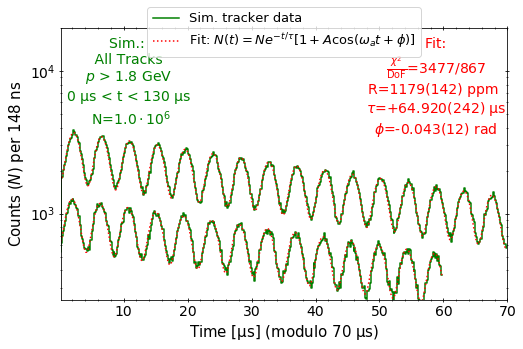

In [6]:
import matplotlib.pyplot as plt
font_size=15

fig, ax = plt.subplots(figsize=(8, 5))

#log the y and set axis scales 
plt.yscale("log")
ax.set_ylim(1e3, 4.0e6)
ax.set_xlim(0, t_mod)
label_data="Data: \n Quality Tracks \n"
legend_data="Run-1 tracker data"
plot_name="_data"
if (not data_bool):
    ax.set_xlim(0.2, t_mod) 
    ax.set_ylim(25e1, 2.0e4)
    label_data="Sim.: \n All Tracks \n"
    legend_data="Sim. tracker data"
    plot_name="_sim"

#split into folds/section for modulo plot 
left=0 
i_section = 0

#loop over folds and plot each section
while left < t_max:
    right=left + t_mod
    mod_filter = (x >= left) & (x<= right) # boolean mask
    #plot data as step-hist. and the fit function
    #plot for that section and label only the 1st
    ax.step(x=x[mod_filter]-left, y=y[mod_filter], where="post", color="g", label=legend_data if i_section==0 else '')
    ax.plot(x[mod_filter]-left, blinded_wiggle_function( x[mod_filter], *par ) , color="red", label=r'Fit: $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$' if i_section==0 else '', linestyle=":")
    left=right # get the next fold 
    i_section += 1
    
#Put legend and pars values 
N_str=cu.sci_notation(N)
cu.textL(ax, 0.152, 0.8, label_data+ r"$p$"+" > 1.8 GeV \n"+str(t_min)+r" $\rm{\mu}$s < t < "+str(t_max)+r" $\rm{\mu}$s"+"\n N="+N_str, font_size=font_size-1,  weight="normal")
# deal with fitted parameters (to display nicely)
parNames=[r"$\tau$", r"$\phi$"]
units=[r"$\rm{\mu}$s", "rad"]
prec=3 # set custom precision 
legned_par=r"$\frac{\chi^2}{\rm{DoF}}$="+str(int(chi2))+"/"+str(int(ndf))+"\nR="+str(int(par[3]))+"("+str(int(par_e[3]))+") ppm \n"
legned_par=cu.legend_par(legned_par,  parNames, (par[1], par[4]), (par_e[1], par_e[4]), units, prec=prec)
cu.textL(ax, 0.84, 0.75, "Fit:\n"+legned_par, font_size=font_size-1, color="red", weight="normal")

#axis labels and ticks
plt.ylabel(r"Counts ($N$) per "+str(int(binW*1e3))+" ns", fontsize=font_size)
plt.xlabel(r"Time [$\mathrm{\mu}$s] (modulo "+str(t_mod)+r" $\mathrm{\mu}$s)", fontsize=font_size)
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='inout')
ax.tick_params(axis='y', which='both', left=True, right=True, direction='inout')
ax.minorticks_on()
plt.xticks(fontsize=font_size-1)
plt.yticks(fontsize=font_size-1)

#save  fig 
# plt.tight_layout()
plt.legend(fontsize=font_size-2, loc='upper center', bbox_to_anchor=(0.5, 1.1) )
plt.savefig("fig/wiggle"+plot_name+".png", dpi=300)